In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from decimal import Decimal
import networkx as nx

In [2]:
Node = 1000
m = 2
times = 100
M_list = [4, 8, 10, 20]
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
w_list = [Decimal("0.00"), Decimal("0.50"), Decimal("0.70"), Decimal("0.90"), Decimal("0.95"), Decimal("0.98")]

In [3]:
for M in M_list:
    for beta in beta_list:
        records = []
        for w in w_list:
            for i in range(times):

                # --- NetworkX (max_loop) 用パス ---
                netx_path = os.path.expanduser(
                    f"~/o_t_hayashilab/network_data/networkX/modular_network/N={Node}/m={m}/beta={beta}/w={w}/Mo={M}/{i}.net"
                )

                # --- Graph-tool (modularity) 用パス ---
                gt_path = os.path.expanduser(
                    f"~/o_t_hayashilab/network_data/graph-tool/modular_network/N={Node}/m={m}/beta={beta}/w={w}/Mo={M}/{i}.gt.gz"
                )

                if not os.path.exists(netx_path):
                    print(f"{netx_path} が見つかりません")
                    continue
                if not os.path.exists(gt_path):
                    print(f"{gt_path} が見つかりません")
                    continue

                # --- NetworkX: 最大ループ長を取得 ---
                with open(netx_path, "r") as f:
                    lines = f.readlines()
                edge_lines = [line for line in lines if not line.startswith("*")]
                edges = [tuple(map(int, line.strip().split())) for line in edge_lines if line.strip()]
                G_nx = nx.Graph()
                G_nx.add_edges_from(edges)
                cycles = nx.cycle_basis(G_nx)
                max_cycle_len = max((len(c) for c in cycles), default=0)

                # --- Graph-tool: モジュラリティを取得 ---
                G_gt = load_graph(gt_path)
                state = gt.BlockState(G_gt, b=G_gt.vp.module_number)
                Q = gt.modularity(G_gt, state.get_blocks())

                # --- 記録 ---
                records.append({
                    "modularity": Q,
                    "max_loop": max_cycle_len,
                    "w": float(w),
                    "beta": beta,
                })

        # --- CSVとして保存 ---
        df = pd.DataFrame(records)
        out_csv = os.path.expanduser(f"~/o_t_hayashilab/network_code/result/beta{beta}_mo{M}_loop_and_modularity.csv")
        df.to_csv(out_csv, index=False)
        print(f"{out_csv} を保存しました")

/home/guest/o_t_hayashilab/network_code/result/beta1_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta0.5_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta0_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta-1_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta-3_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta-5_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta-10_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta-100_mo4_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta1_mo8_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta0.5_mo8_loop_and_modularity.csv を保存しました
/home/guest/o_t_hayashilab/network_code/result/beta0_mo8_loop_and_modularity.csv を保存しました
/home/gue

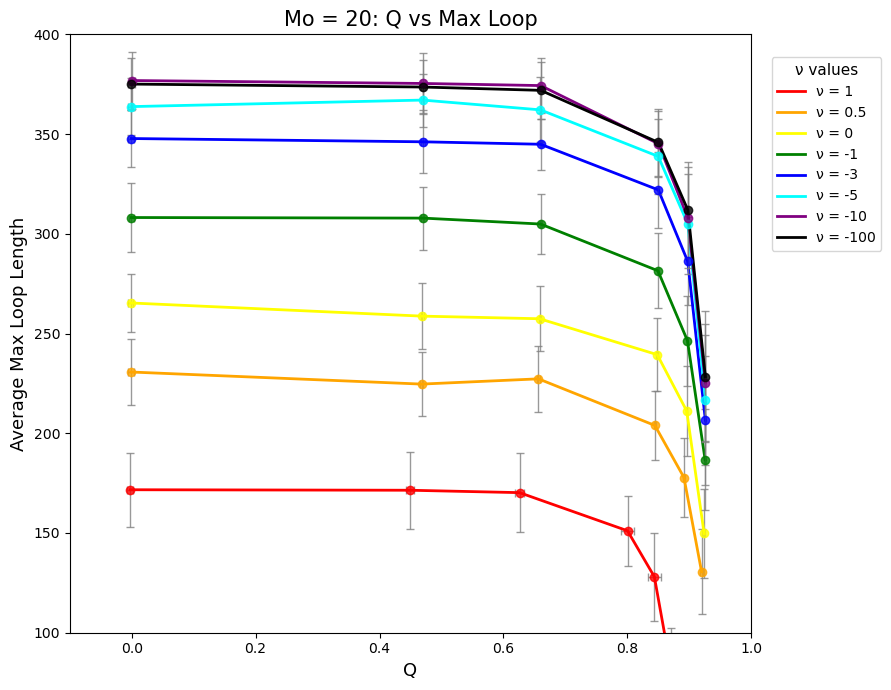

In [6]:
color_list = [
    "red",       # β = 1
    "orange",    # β = 0.5
    "yellow",    # β = 0
    "green",     # β = -1
    "blue",      # β = -3
    "cyan",      # β = -5
    "purple",    # β = -10
    "black",     # β = -100
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# betaのリストと色の固定対応
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
color_list = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", "black"]
color_map = dict(zip(beta_list, color_list))

Mo = 20  # 固定

plt.figure(figsize=(9, 7))

for beta in beta_list:
    # CSVファイルパス
    csv_path = os.path.expanduser(f"~/o_t_hayashilab/network_code/result/beta{beta}_mo{Mo}_loop_and_modularity.csv")
    if not os.path.exists(csv_path):
        print(f"{csv_path} が見つかりません。スキップします。")
        continue
    
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["modularity", "max_loop"])  # 欠損除去

    # wごとの平均・標準偏差を計算（Q, max_loop）
    means = df.groupby("w").agg({"modularity": "mean", "max_loop": "mean"})
    stds = df.groupby("w").agg({"modularity": "std", "max_loop": "std"})

    for w in w_list:
        if float(w) not in df["w"].values:
            continue
        sub = df[df["w"] == float(w)]
        mean_mod = sub["modularity"].mean()
        mean_loop = sub["max_loop"].mean()
        std_mod = sub["modularity"].std()
        std_loop = sub["max_loop"].std()

        # エラーバー付き散布図
        plt.errorbar(mean_mod, mean_loop, xerr=std_mod, yerr=std_loop,
                     fmt='o', color=color_map[beta], ecolor="gray", elinewidth=1, capsize=3, alpha=0.8)

    # トレンド線（平均値の推移を線でつなぐ）
    plt.plot(means["modularity"], means["max_loop"], '-', linewidth=2,
             color=color_map[beta], label=f"ν = {beta}")

plt.xlabel("Q", fontsize=13)
plt.ylabel("Average Max Loop Length", fontsize=13)
plt.title(f"Mo = {Mo}: Q vs Max Loop", fontsize=15)
plt.xlim(-0.1, 1.0)
plt.ylim(100, 400)
plt.legend(
    title="ν values",
    fontsize=10,
    title_fontsize=11,
    loc="center left",         # 凡例の表示位置（右端中央）
    bbox_to_anchor=(1.02, 0.8) # グラフ外に少し離して配置
)
plt.grid(False)
plt.subplots_adjust(right=0.8)  # ← これを追加！
plt.tight_layout()
plt.show()

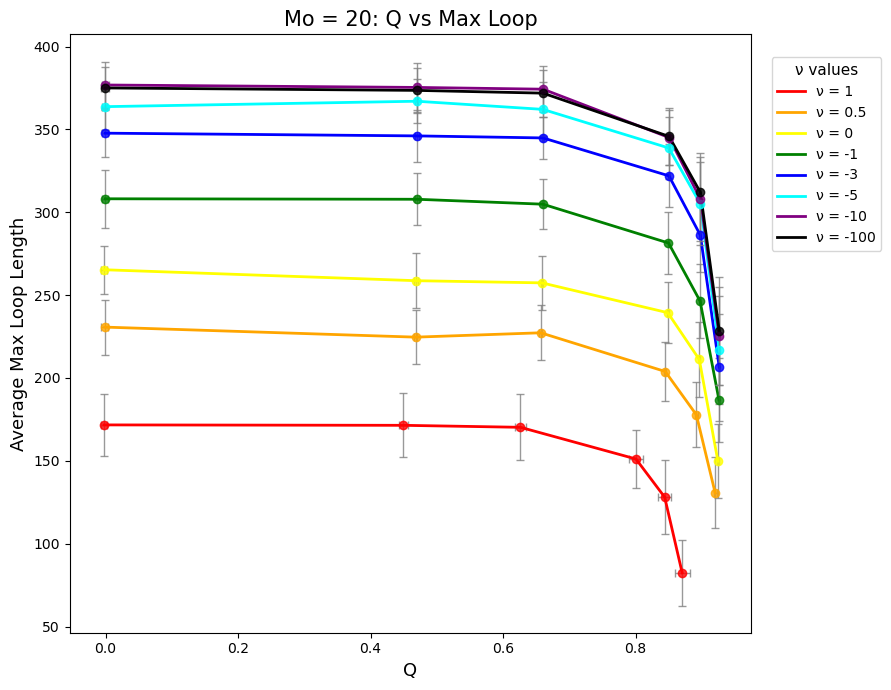

In [11]:
color_list = [
    "red",       # β = 1
    "orange",    # β = 0.5
    "yellow",    # β = 0
    "green",     # β = -1
    "blue",      # β = -3
    "cyan",      # β = -5
    "purple",    # β = -10
    "black",     # β = -100
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# betaのリストと色の固定対応
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
color_list = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", "black"]
color_map = dict(zip(beta_list, color_list))

Mo = 20  # 固定

plt.figure(figsize=(9, 7))

for beta in beta_list:
    # CSVファイルパス
    csv_path = os.path.expanduser(f"~/o_t_hayashilab/network_code/result/beta{beta}_mo{Mo}_loop_and_modularity.csv")
    if not os.path.exists(csv_path):
        print(f"{csv_path} が見つかりません。スキップします。")
        continue
    
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["modularity", "max_loop"])  # 欠損除去

    # wごとの平均・標準偏差を計算（Q, max_loop）
    means = df.groupby("w").agg({"modularity": "mean", "max_loop": "mean"})
    stds = df.groupby("w").agg({"modularity": "std", "max_loop": "std"})

    for w in w_list:
        if float(w) not in df["w"].values:
            continue
        sub = df[df["w"] == float(w)]
        mean_mod = sub["modularity"].mean()
        mean_loop = sub["max_loop"].mean()
        std_mod = sub["modularity"].std()
        std_loop = sub["max_loop"].std()

        # エラーバー付き散布図
        plt.errorbar(mean_mod, mean_loop, xerr=std_mod, yerr=std_loop,
                     fmt='o', color=color_map[beta], ecolor="gray", elinewidth=1, capsize=3, alpha=0.8)

    # トレンド線（平均値の推移を線でつなぐ）
    plt.plot(means["modularity"], means["max_loop"], '-', linewidth=2,
             color=color_map[beta], label=f"ν = {beta}")

plt.xlabel("Q", fontsize=13)
plt.ylabel("Average Max Loop Length", fontsize=13)
plt.title(f"Mo = {Mo}: Q vs Max Loop", fontsize=15)
plt.legend(
    title="ν values",
    fontsize=10,
    title_fontsize=11,
    loc="center left",         # 凡例の表示位置（右端中央）
    bbox_to_anchor=(1.02, 0.8) # グラフ外に少し離して配置
)
plt.grid(False)
plt.subplots_adjust(right=0.8)  # ← これを追加！
plt.tight_layout()
plt.show()